# Model (ResNet) - Binary

Within this model, we'll use the same VGG16 model, but reduce the options down to 'Subuaru' and 'Not Subaru'

### Library Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import pickle
import time
import os
import json
import seaborn as sns
import tensorflow as tf
import random
import cv2
import copy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.transforms as transforms



from tensorflow.keras.applications import VGG16,InceptionV3
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

from keras.applications import VGG16
from keras.applications.resnet import ResNet152
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

from pandas import json_normalize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score,classification_report
from sklearn.preprocessing import normalize,StandardScaler,RobustScaler,MinMaxScaler
from sklearn.svm import SVC,LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.compose import ColumnTransformer



from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Conv2D, MaxPooling2D,LeakyReLU
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist, cifar10

from tensorflow import keras
from keras.utils import to_categorical
from keras import regularizers
from keras.models import load_model
from keras.layers import GlobalAveragePooling2D
from keras.losses import binary_crossentropy

from scipy.stats import skew
from tqdm import tqdm
from PIL import Image
from sklearn import metrics


### Data Augmentation

In [2]:
# #Remove comment to run again
# datagen = ImageDataGenerator(
#     rotation_range=20,
# #     width_shift_range=0.15,
# #     height_shift_range=0.15,
#     shear_range=0.1,
#     zoom_range=0.1,
#     horizontal_flip=True,
#     vertical_flip=False,
# #     fill_mode='nearest'
# )

In [3]:
# image_dir = "Datasets/BoundingBoxes/"

# for root, dirs, files in os.walk(image_dir):
#     for filename in files:
#         if not filename.startswith('.'):
#             if os.path.basename(root).startswith('subaru'):
#                 filepath = os.path.join(root, filename)
#                 # load the image and convert it to a numpy array
#                 img = load_img(filepath)
#                 img_array = img_to_array(img)
#                 # reshape the array to have an extra dimension
#                 img_array = img_array.reshape((1,) + img_array.shape)
#                 # generate X (in range) augmented images and save them
#                 for i in range(4):
#                     aug_img_array = datagen.flow(img_array, batch_size=1)[0]
#                     aug_img = aug_img_array.astype('uint8')
#                     new_filename = f"{filename.split('.')[0]}_aug{i}.jpg"
#                     new_filepath = os.path.join(root, new_filename)
#                     # save the augmented image
#                     Image.fromarray(aug_img.squeeze()).save(new_filepath)
#                     print(f"New file created: {new_filepath}")

### Generator (Data Generator)

In [4]:
image_dir = "Datasets/BoundingBoxes/"

In [5]:
def image_data_generator(image_dir, batch_size):
    images = []
    labels = []
    for brand_dir in os.listdir(image_dir):
        if not brand_dir.startswith('.'):
            for filename in os.listdir(os.path.join(image_dir, brand_dir)):
                if not filename.startswith('.'):
                    label = brand_dir
                    filepath = os.path.join(image_dir, brand_dir, filename)
                    image = cv2.imread(filepath)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    image = cv2.resize(image, (224, 224))
                    images.append(image)
                    labels.append(label)
                    if len(images) == batch_size:
                        labels = np.array(labels)
                        labels = np.where(np.array([label.split('_')[0] for label in labels]) == 'subaru', 1, 0)
                        yield np.array(images), np.array(labels)
                        images = []
                        labels = []
    if len(images) > 0:
        labels = np.array(labels)
        labels = np.where(np.array([label.split('_')[0] for label in labels]) == 'subaru', 1, 0)
        yield np.array(images), np.array(labels)

In [6]:
all_images = []
all_labels = []

for batch_images, batch_labels in image_data_generator(image_dir, batch_size=50000):
    all_images.append(batch_images)
    all_labels.append(batch_labels)

all_images = np.concatenate(all_images, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

In [7]:
len(all_labels)

207368

In [8]:
1-(sum(all_labels)/len(all_labels)) ## baseline

0.6115601249951776

In [16]:
num_classes = len(np.unique(all_labels))
num_classes

2

### Train Test Split

To Train-Test split the data, we'll be seperating X on index to prevent all of the data from being loaded into the kernel concurrently.

In [17]:
idx = np.arange(len(all_images))
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=all_labels)

In [18]:
X_train, y_train = all_images[train_idx], all_labels[train_idx]

In [19]:
X_test, y_test = all_images[test_idx], all_labels[test_idx]

In [20]:
# y_train = np.reshape(y_train, (-1, 1))
# y_test = np.reshape(y_test, (-1, 1))

In [21]:
len(y_test)

41474

In [22]:
print('Subaru count:', np.sum(y_train))
print('Other count:', np.sum(1 - y_train))

Subaru count: 64440
Other count: 101454


### Data Generators

We'll feed our data into the model in batches of 32 so that all images aren’t loaded into the kernel at the same time. Within this function, we'll divide X_low by 255, to normalize the data.

This operation is split into two seperate generators to prevent data leakage from the training set into the validation set. Since the function has been seperated, each function will only be called when needed.

In [23]:
def train_data_generator(X_train, y_train, batch_size):
    num_train_samples = len(X_train)
    train_indices = np.arange(num_train_samples)
    np.random.shuffle(train_indices)

    while True:
        for start_idx in range(0, num_train_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_train_samples)
            batch_indices = train_indices[start_idx:end_idx]
            X_batch_train = torch.tensor(X_train[batch_indices], dtype=torch.float32)
            y_batch_train = torch.tensor(y_train[batch_indices], dtype=torch.long)

#             # Normalize the input data to [0, 1]
#             X_batch_train /= 255.0

            yield X_batch_train, y_batch_train

In [24]:
def test_data_generator(X_test, y_test, batch_size):
    num_test_samples = len(X_test)
    test_indices = torch.randperm(num_test_samples)
    while True:
        for start_idx_test in range(0, num_test_samples, batch_size):
            end_idx_test = min(start_idx_test + batch_size, num_test_samples)
            batch_indices_test = test_indices[start_idx_test:end_idx_test]
            batch_X_test = torch.tensor(X_test[batch_indices_test], dtype=torch.float32)
            batch_y_test = torch.tensor(y_test[batch_indices_test], dtype=torch.long)
            yield batch_X_test, batch_y_test

In [25]:
batch_size = 32
train_generator = train_data_generator(X_train, y_train, batch_size)
val_generator = test_data_generator(X_test, y_test, batch_size)

In [26]:
train_steps = len(X_train) // batch_size
val_steps = len(X_test) // batch_size

### Instantiating VGG16 Model (TensorFlow)

In [27]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_fn = tf.keras.losses.BinaryCrossentropy()
metrics=['accuracy']
epochs = 50

In [28]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

Metal device set to: Apple M1 Max


2023-05-15 08:41:24.614989: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-15 08:41:24.615889: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [29]:
model = Sequential([
    base_model,
    Flatten(),
    Dense(1, activation='sigmoid')
])

In [30]:
model.compile(optimizer= optimizer,
              loss= loss_fn,
              metrics= metrics)

In [31]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10)


In [32]:
model.fit(train_generator,
          epochs=50,
          validation_data=val_generator,
          callbacks=[early_stopping],
          steps_per_epoch=train_steps, 
          validation_steps=val_steps)

Epoch 1/50


2023-05-15 08:41:38.909337: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-05-15 08:41:40.322245: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5184/5184 [==============================] - ETA: 0s - loss: 1.9054 - accuracy: 0.8271

2023-05-15 08:46:31.370752: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5184/5184 [==============================] - 360s 69ms/step - loss: 1.9054 - accuracy: 0.8271 - val_loss: 1.3806 - val_accuracy: 0.8715
Epoch 2/50
5184/5184 [==============================] - 349s 67ms/step - loss: 1.5119 - accuracy: 0.8593 - val_loss: 1.4429 - val_accuracy: 0.8767
Epoch 3/50
5184/5184 [==============================] - 347s 67ms/step - loss: 1.4598 - accuracy: 0.8671 - val_loss: 1.9554 - val_accuracy: 0.8028
Epoch 4/50
5184/5184 [==============================] - 351s 68ms/step - loss: 1.4037 - accuracy: 0.8732 - val_loss: 2.6138 - val_accuracy: 0.7740
Epoch 5/50
5184/5184 [==============================] - 378s 73ms/step - loss: 1.3654 - accuracy: 0.8776 - val_loss: 1.2311 - val_accuracy: 0.8881
Epoch 6/50
5184/5184 [==============================] - 349s 67ms/step - loss: 1.2919 - accuracy: 0.8821 - val_loss: 2.2147 - val_accuracy: 0.8586
Epoch 7/50
5184/5184 [==============================] - 351s 68ms/step - loss: 1.3186 - accuracy: 0.8835 - val_loss: 1.9160 - val

In [43]:
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)
y_pred_prob = model.predict(X_test)

threshold = 0.2

# Classify examples based on the threshold
y_pred = np.where(y_pred_prob > threshold, 1, 0)

1297/1297 [==============================] - 90s 70ms/step


In [44]:
predictions = model.predict(X_test)
print(classification_report(y_test, np.argmax(y_pred_labels, axis=1))) 

1297/1297 [==============================] - 97s 75ms/step
              precision    recall  f1-score   support

           0       0.61      1.00      0.76     25364
           1       0.00      0.00      0.00     16110

    accuracy                           0.61     41474
   macro avg       0.31      0.50      0.38     41474
weighted avg       0.37      0.61      0.46     41474



/Users/ryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryan/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

<Axes: >

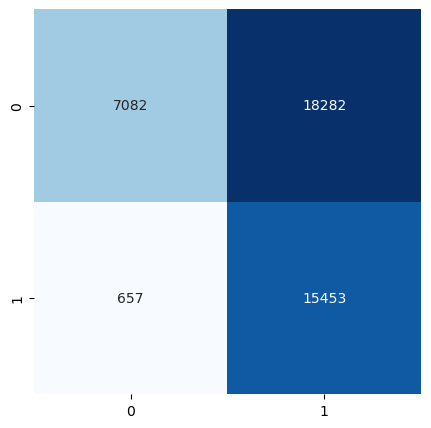

In [37]:
cm = confusion_matrix(y_test, y_pred_labels)

# Create a heatmap using seaborn
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)

In [38]:
cm

array([[ 7082, 18282],
       [  657, 15453]])

In [39]:
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score = 2 * (precision * recall) / (precision + recall)

In [40]:
accuracy, precision, recall, f1_score

(0.5433524617832859, 0.458070253445976, 0.9592178770949721, 0.6200421306048751)

In [41]:
### Model results

1) ResNet150 Model
    - bounding boxes with multiple augmentations completed for subaru images
    - acc,prec,recall,f1_score (0.5754930800019289,0.47765162832387215,0.9923649906890131,0.6448971359419121)
    - baseline .625 (base_model = ResNet152(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    - converges to .999999 accuracy on model, .989 validation

In [46]:
model.save('models/Inception_v3_custom/')

INFO:tensorflow:Assets written to: models/Inception_v3_custom/assets


INFO:tensorflow:Assets written to: models/Inception_v3_custom/assets
